<div align="center">
    
# Asset Finance Risk Assessment Model
## Feature Engineering and Data Preprocessing

> Author: [Mithamo Beth](https://github.com/Mythamor) 
</div>

## Feature Engineering

In [1]:
# Import the relevant libraries
import pandas as pd
import numpy as np
import duckdb
import sweetviz as sv

# Visualization libraries
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Set the layout
sns.set_style("darkgrid");

# Set the color palette
sns.set_palette("Set2");

# Set the default figsize
plt.rcParams["figure.figsize"] = (6, 4);

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load assessment dataframe
df = pd.read_csv('../data/assessment.csv')
df.head()

,UNIQUEID,Disbursed_amount,Asset_cost,Ltv,Manufacturer_id,Date_of_birth,Employment_type,Disbursal_date,State_id,Aadhar_flag,Voterid_flag,Perform_cns_score,Perform_cns_score_description,Pri_no_of_accts,Pri_active_accts,New_accts_in_last_six_months,No_of_inquiries,Loan_default,Average_loan_tenure,Credit_history_length_months
0,420825,50578,58400,89.55,45,1984-01-01,Salaried,2018-08-03,6,1,0,0,No Bureau History Available,0,0,0,0,0,0,0
1,537409,47145,65550,73.23,45,1985-07-31,Self employed,2018-09-26,6,1,0,598,I-Medium Risk,1,1,0,0,1,23,23
2,417566,53278,61360,89.63,45,1985-08-24,Self employed,2018-08-01,6,1,0,0,No Bureau History Available,0,0,0,0,0,0,0
3,624493,57513,66113,88.48,45,1993-12-30,Self employed,2018-10-26,6,1,0,305,L-Very High Risk,3,0,0,1,1,8,15
4,539055,52378,60300,88.39,45,1977-12-09,Self employed,2018-09-26,6,1,0,0,No Bureau History Available,0,0,0,1,1,0,0


In [3]:
# Calculate the borrowers age at the time of disbursal
# Step 1: Convert to datetime format
df['Disbursal_date'] = pd.to_datetime(df['Disbursal_date'], format='%Y-%m-%d')
df['Date_of_birth'] = pd.to_datetime(df['Date_of_birth'], format='%Y-%m-%d')

# Step 2: Calculate age at the time of disbursal in days
df['Age_in_days'] = (df['Disbursal_date'] - df['Date_of_birth']).dt.days

# Step 3: Convert days to years
df['Age'] = df['Age_in_days'] // 365  # Use integer division to get complete years

# Optional: Drop the 'Age_in_days' column if you only need the final age
df.drop(columns=['Age_in_days', 'Disbursal_date', 'Date_of_birth'], inplace=True)

In [4]:
# Investigate the age statistics 
print(df.Age.describe()) 
print('\nAge of youngest borrower:',df.Age.min())
print('Age of oldest borrower:',df.Age.max())
print('Median Age:',df.Age.median())

count    233154.000000
mean         33.954142
std           9.821186
min          18.000000
25%          26.000000
50%          32.000000
75%          41.000000
max          69.000000
Name: Age, dtype: float64

Age of youngest borrower: 18
Age of oldest borrower: 69
Median Age: 32.0


The distribution is right skewed

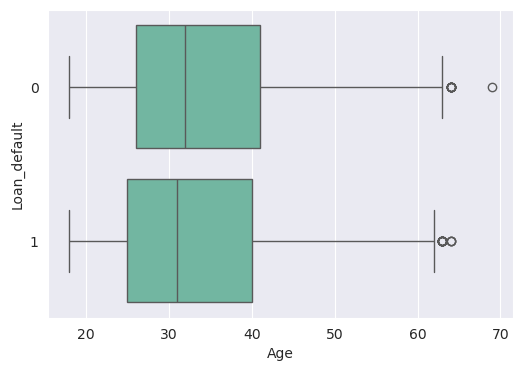

In [5]:
# Plot a bxplot to check the distribution and confirm the right tail
sns.boxplot(x='Age', y='Loan_default', data=df, orient="h")
plt.show()

In [6]:
# Age summary grouped by loan default
print(df.groupby('Age')['Loan_default'].mean().sort_values(ascending=False).head(10))
print()
print(df.groupby('Age')['Loan_default'].mean().sort_values(ascending=True).head(10))

Age
20    0.253623
21    0.251974
18    0.250000
22    0.244091
23    0.235699
19    0.235023
26    0.234047
24    0.231651
64    0.230769
25    0.229053
Name: Loan_default, dtype: float64

Age
69    0.000000
63    0.112782
62    0.126623
60    0.166667
59    0.172680
54    0.179338
44    0.179699
61    0.180952
57    0.183388
52    0.188621
Name: Loan_default, dtype: float64


Younger borrowers have a much higher default rate compared to the older borrowers. Age therefore plays an important role when determining loan disbursement. Borrowers between the ages of 17-25 are higher risk than borrowers over 55 years.

## Binning continuous data

In [7]:
def bin_column(df, column_name, bin_width, min_value, max_value):
    """
    Bins a column into defined ranges and creates labels dynamically.

    Parameters:
    - df (pd.DataFrame): DataFrame containing the column to be binned.
    - column_name (str): The column name to bin.
    - bin_width (int): The width of each bin.
    - min_value (int): The minimum value for binning.
    - max_value (int): The maximum value for binning.

    Returns:
    - pd.Series: Binned data with dynamically generated labels.
    """
    bins = np.arange(min_value, max_value + bin_width, bin_width) 
    labels = [f"{bins[i]}-{bins[i+1]-1}" for i in range(len(bins)-1)]
    
    # Apply binning
    return pd.cut(df[column_name], bins=bins, labels=labels, right=False)




In [8]:
# Example usage for a specific column like Disbursed_amount
df['Disbursed_bracket'] = bin_column(df, 'Disbursed_amount', bin_width=10000, min_value=12000, max_value=200000)
df['Disbursed_bracket'].value_counts(normalize=True)

Disbursed_bracket
52000-61999      0.368008
42000-51999      0.290726
62000-71999      0.139032
32000-41999      0.101717
72000-81999      0.043042
22000-31999      0.027137
82000-91999      0.013489
92000-101999     0.010260
12000-21999      0.003153
112000-121999    0.001377
102000-111999    0.000987
122000-131999    0.000493
132000-141999    0.000197
142000-151999    0.000159
152000-161999    0.000103
162000-171999    0.000060
172000-181999    0.000034
182000-191999    0.000021
192000-201999    0.000004
Name: proportion, dtype: float64

In [9]:
# Example usage for a specific column like Disbursed_amount
df['Asset_bracket'] = bin_column(df, 'Asset_cost', bin_width=10000, min_value=37000, max_value=200000)
df['Asset_bracket'].value_counts(normalize=True)

Asset_bracket
67000-76999      0.393091
57000-66999      0.271968
77000-86999      0.124813
87000-96999      0.057829
97000-106999     0.053607
47000-56999      0.029519
107000-116999    0.026902
117000-126999    0.010932
37000-46999      0.009744
127000-136999    0.005239
157000-166999    0.004072
137000-146999    0.003535
147000-156999    0.003475
167000-176999    0.003381
177000-186999    0.001090
187000-196999    0.000506
197000-206999    0.000296
Name: proportion, dtype: float64

In [10]:
# Ltv binning
df['Ltv_bracket'] = bin_column(df, 'Ltv', bin_width=15, min_value=10, max_value=95)
df['Ltv_bracket'].value_counts(normalize=True)

Ltv_bracket
70-84    0.546647
55-69    0.213447
85-99    0.173002
40-54    0.055749
25-39    0.010401
10-24    0.000755
Name: proportion, dtype: float64

In [11]:
# Binning Cns score
df['Cns_score_bracket'] = bin_column(df, 'Perform_cns_score', bin_width=150, min_value=0, max_value=900)
df['Cns_score_bracket'].value_counts(normalize=True)

Cns_score_bracket
0-149      0.556649
600-749    0.215849
750-899    0.110288
300-449    0.062542
450-599    0.054672
150-299    0.000000
Name: proportion, dtype: float64

In [12]:
# Binning age
df['Age_bracket'] = bin_column(df, 'Age', bin_width=10, min_value=18, max_value=69)
df['Age_bracket'].value_counts(normalize=True)

Age_bracket
28-37    0.345008
18-27    0.319887
38-47    0.221159
48-57    0.099171
58-67    0.014771
68-77    0.000004
Name: proportion, dtype: float64

In [13]:
# Binning credit history length
df['Credit_history_length_months'] = (df['Credit_history_length_months'] ).round(2)
df['Credit_bracket'] = bin_column(df, 'Credit_history_length_months', bin_width=3, min_value=0, max_value=39)
df['Credit_bracket'].value_counts(normalize=True)

Credit_bracket
0-2      0.610272
6-8      0.055773
24-26    0.051474
12-14    0.042764
9-11     0.036714
3-5      0.030827
15-17    0.029869
21-23    0.029745
18-20    0.029710
36-38    0.022092
27-29    0.020652
30-32    0.020434
33-35    0.019675
Name: proportion, dtype: float64

In [14]:
# Example usage for a specific column like Disbursed_amount
df['Average_loan_tenure'] = (df['Average_loan_tenure'] / 12).round(2)
df['Loan_tenure_bracket'] = bin_column(df, 'Average_loan_tenure', bin_width=3, min_value=0, max_value=50)
df['Loan_tenure_bracket'].value_counts(normalize=True)

Loan_tenure_bracket
0-2      0.943063
3-5      0.048273
6-8      0.006481
9-11     0.001634
12-14    0.000459
15-17    0.000073
30-32    0.000004
24-26    0.000004
21-23    0.000004
18-20    0.000004
27-29    0.000000
33-35    0.000000
36-38    0.000000
39-41    0.000000
42-44    0.000000
45-47    0.000000
48-50    0.000000
Name: proportion, dtype: float64

## Initial feature selection

In [15]:
# Select a few features to train on the dataset
df_1 = df[['Disbursed_amount', 'Asset_cost', 'Ltv', 'Manufacturer_id',
       'Employment_type', 'State_id', 'Aadhar_flag', 'Voterid_flag',
       'Perform_cns_score', 'Pri_no_of_accts', 'Pri_active_accts',
       'New_accts_in_last_six_months', 'No_of_inquiries', 'Loan_default',
       'Average_loan_tenure', 'Credit_history_length_months',
       'Perform_cns_score_description', 'Age'
          ]]
df_1.shape

(233154, 18)

## Data Preprocessing

In [16]:
# Import preprocessing libraries
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

In [26]:
# Split the target and predictor variables
X = df_1.drop(['Loan_default'], axis=1)
y = df_1['Loan_default']

# Perfrom a train test split
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.25, random_state=42)

print('X_train:', X_train.shape, '\n X_test:',X_test.shape)
print('y_train:', y_train.shape, '\n y_test:',y_test.shape)

X_train: (174865, 17) 
 X_test: (58289, 17)
y_train: (174865,) 
 y_test: (58289,)


In [27]:
y_train.head()

179568    0
5035      0
31099     0
47710     0
5813      0
Name: Loan_default, dtype: int64

In [28]:
# Export dataframe with key features
df_1.to_csv('../data/new_df.csv', index=True)

In [29]:
# Only select columns of numeric data types
numeric_cols = X.select_dtypes(['float64', 'int64'])

# Exclude columns containing "id" and "flag" in their names
exclude_cols = X.columns[X.columns.str.contains('id|flag', case=False)]

# Drop the selected columns
numeric_cols = numeric_cols.drop(exclude_cols, axis=1)

print(numeric_cols.shape)
print()
print(numeric_cols.columns)
numeric_cols.head()

(233154, 10)

Index(['Disbursed_amount', 'Asset_cost', 'Ltv', 'Perform_cns_score',
       'Pri_no_of_accts', 'Pri_active_accts', 'New_accts_in_last_six_months',
       'Average_loan_tenure', 'Credit_history_length_months', 'Age'],
      dtype='object')


,Disbursed_amount,Asset_cost,Ltv,Perform_cns_score,Pri_no_of_accts,Pri_active_accts,New_accts_in_last_six_months,Average_loan_tenure,Credit_history_length_months,Age
0,50578,58400,89.55,0,0,0,0,0.00,0,34
1,47145,65550,73.23,598,1,1,0,1.92,23,33
2,53278,61360,89.63,0,0,0,0,0.00,0,32
3,57513,66113,88.48,305,3,0,0,0.67,15,24
4,52378,60300,88.39,0,0,0,0,0.00,0,40


In [30]:
# Select columns of categorical variable
category_cols = X.select_dtypes(['object', 'category'])

# Include columns containing "id" and "flag" in their names
include_cols = X.columns[X.columns.str.contains('id|flag', case=True)]

# Concatenate the selected columns
category_cols = pd.concat([category_cols, X.loc[:, include_cols]], axis=1)

print(category_cols.shape)
print()
print(category_cols.columns)
category_cols.head()

(233154, 7)

Index(['Employment_type', 'No_of_inquiries', 'Perform_cns_score_description',
       'Manufacturer_id', 'State_id', 'Aadhar_flag', 'Voterid_flag'],
      dtype='object')


,Employment_type,No_of_inquiries,Perform_cns_score_description,Manufacturer_id,State_id,Aadhar_flag,Voterid_flag
0,Salaried,0,No Bureau History Available,45,6,1,0
1,Self employed,0,I-Medium Risk,45,6,1,0
2,Self employed,0,No Bureau History Available,45,6,1,0
3,Self employed,1,L-Very High Risk,45,6,1,0
4,Self employed,1,No Bureau History Available,45,6,1,0


In [31]:
print(f'The categorical columns are:\n {category_cols.columns}\n')
print(f'The numerical columns are:\n {numeric_cols.columns}')

The categorical columns are:
 Index(['Employment_type', 'No_of_inquiries', 'Perform_cns_score_description',
       'Manufacturer_id', 'State_id', 'Aadhar_flag', 'Voterid_flag'],
      dtype='object')

The numerical columns are:
 Index(['Disbursed_amount', 'Asset_cost', 'Ltv', 'Perform_cns_score',
       'Pri_no_of_accts', 'Pri_active_accts', 'New_accts_in_last_six_months',
       'Average_loan_tenure', 'Credit_history_length_months', 'Age'],
      dtype='object')


In [32]:
X_test.columns

Index(['Disbursed_amount', 'Asset_cost', 'Ltv', 'Manufacturer_id',
       'Employment_type', 'State_id', 'Aadhar_flag', 'Voterid_flag',
       'Perform_cns_score', 'Pri_no_of_accts', 'Pri_active_accts',
       'New_accts_in_last_six_months', 'No_of_inquiries',
       'Average_loan_tenure', 'Credit_history_length_months',
       'Perform_cns_score_description', 'Age'],
      dtype='object')

## Ohe Transformation

In [36]:
# Ensure these are correct numeric and categorical columns
numeric_cols = X_train.select_dtypes(include=['int64', 'float64'])
category_cols = X_train.select_dtypes(include=['object', 'category'])

# Instatiate the MinMaxScaler
scaler = MinMaxScaler()

# Instatiate the OneHotEncoding
ohe = OneHotEncoder(drop='first', handle_unknown='ignore')

#fit_tranform the training data
scaled_Xtrain = scaler.fit_transform(numeric_cols)
ohe_Xtrain = ohe.fit_transform(category_cols)

#transform the test data
scaled_Xtest = scaler.transform(X_test[numeric_cols.columns])
ohe_Xtest = ohe.transform(X_test[category_cols.columns])

# Create new training dataframe
trans_X_train = pd.concat([
    pd.DataFrame(scaled_Xtrain, columns=numeric_cols.columns, index=X_train.index),
    pd.DataFrame(ohe_Xtrain.toarray(), columns=ohe.get_feature_names_out(), index=X_train.index)
], axis=1)


# Test data

# Create new test data dataframe
trans_X_test = pd.concat([
    pd.DataFrame(scaled_Xtest, columns=numeric_cols.columns, index=X_test.index),
    pd.DataFrame(ohe_Xtest.toarray(), columns=ohe.get_feature_names_out(), index=X_test.index)
], axis=1)

#check the new X_test dataframe
print(trans_X_train.shape)
print(trans_X_test.shape)

(174865, 38)
(58289, 38)


## Label encoder Transformation

In [37]:
from sklearn.preprocessing import LabelEncoder

# Instantiate the LabelEncoder
le = LabelEncoder()

# Fit and transform the training data for categorical columns
for col in category_cols.columns:
    X_train[col] = le.fit_transform(X_train[col])

# Transform the test data for categorical columns
for col in category_cols.columns:
    X_test[col] = le.transform(X_test[col])

# Scale the numerical columns
scaled_Xtrain = scaler.fit_transform(X_train[numeric_cols.columns])
scaled_Xtest = scaler.transform(X_test[numeric_cols.columns])

# Create new training dataframe
le_X_train = pd.concat([
    pd.DataFrame(scaled_Xtrain, columns=numeric_cols.columns, index=X_train.index),
    X_train[category_cols.columns].reset_index(drop=True)
], axis=1)

# Create new test data dataframe
le_X_test = pd.concat([
    pd.DataFrame(scaled_Xtest, columns=numeric_cols.columns, index=X_test.index),
    X_test[category_cols.columns].reset_index(drop=True)
], axis=1)

# Check the new X_train and X_test dataframe
print(le_X_train.shape)
print(le_X_test.shape)


(218436, 38)
(102109, 38)


In [38]:
le_X_train.head()

,Disbursed_amount,Asset_cost,Ltv,Manufacturer_id,State_id,Aadhar_flag,Voterid_flag,Perform_cns_score,Pri_no_of_accts,Pri_active_accts,...,Perform_cns_score_description_K-High Risk,Perform_cns_score_description_L-Very High Risk,Perform_cns_score_description_M-Very High Risk,Perform_cns_score_description_No Bureau History Available,Perform_cns_score_description_Not Scored: More than 50 active Accounts found,Perform_cns_score_description_Not Scored: No Activity seen on the customer (Inactive),Perform_cns_score_description_Not Scored: No Updates available in last 36 months,Perform_cns_score_description_Not Scored: Not Enough Info available on the customer,Perform_cns_score_description_Not Scored: Only a Guarantor,Perform_cns_score_description_Not Scored: Sufficient History Not Available
179568,0.052762,0.024006,0.927362,0.000000,0.095238,1.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5035,0.056126,0.041807,0.663804,0.054054,0.095238,0.0,1.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
31099,0.035026,0.015270,0.811043,0.000000,0.238095,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
47710,0.031444,0.019528,0.663313,0.369369,0.380952,1.0,0.0,0.926966,0.006623,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5813,0.022466,0.011963,0.644417,0.000000,0.095238,1.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


## Export train and test dataframes

In [39]:
trans_X_train.to_csv('../data/X_train.csv', index=True)
y_train.to_csv('../data/y_train.csv', index=True)
trans_X_test.to_csv('../data/X_test.csv', index=True)
y_test.to_csv('../data/y_test.csv', index=True)

## Feature Selection

### Correlation

In [40]:
# Drop non-numeric columns
numeric_df = df_1.select_dtypes(include=['int64', 'float64'])

# Calculate correlations
correlations = numeric_df.corr()['Loan_default'].abs().sort_values(ascending=False)
print(correlations)

Loan_default                    1.000000
Ltv                             0.098208
Disbursed_amount                0.077675
Perform_cns_score               0.057929
State_id                        0.048075
Voterid_flag                    0.043747
Credit_history_length_months    0.042126
Aadhar_flag                     0.041593
Pri_active_accts                0.041451
Age                             0.036549
Pri_no_of_accts                 0.035456
New_accts_in_last_six_months    0.029400
Manufacturer_id                 0.025039
Average_loan_tenure             0.024782
Asset_cost                      0.014261
Name: Loan_default, dtype: float64


### Recursive Feature Elimination

In [41]:
# RFE feature selection
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

model = LogisticRegression()

rfe = RFE(model, n_features_to_select=20)

rfe.fit(X_train, y_train)

selected_features = X_train.columns[rfe.support_]
print(selected_features)

Index(['Disbursed_amount', 'Asset_cost', 'Ltv', 'Manufacturer_id', 'State_id',
       'Perform_cns_score', 'Pri_no_of_accts', 'Pri_active_accts',
       'New_accts_in_last_six_months', 'Average_loan_tenure',
       'Credit_history_length_months', 'Age', 'No_of_inquiries_2',
       'No_of_inquiries_3+',
       'Perform_cns_score_description_No Bureau History Available',
       'Perform_cns_score_description_Not Scored: No Activity seen on the customer (Inactive)',
       'Perform_cns_score_description_Not Scored: No Updates available in last 36 months',
       'Perform_cns_score_description_Not Scored: Not Enough Info available on the customer',
       'Perform_cns_score_description_Not Scored: Only a Guarantor',
       'Perform_cns_score_description_Not Scored: Sufficient History Not Available'],
      dtype='object')


### Lasso Regression

In [42]:
# Lasso feature selection 
lasso_log = LogisticRegression(penalty='l1', solver='liblinear')

lasso_log.fit(X_train, y_train)

selected_features = X_train.columns[lasso_log.coef_[0] != 0]

print(len(selected_features))
print(selected_features)

37
Index(['Disbursed_amount', 'Asset_cost', 'Ltv', 'Manufacturer_id', 'State_id',
       'Aadhar_flag', 'Voterid_flag', 'Perform_cns_score', 'Pri_no_of_accts',
       'Pri_active_accts', 'New_accts_in_last_six_months',
       'Average_loan_tenure', 'Credit_history_length_months', 'Age',
       'Employment_type_Salaried', 'Employment_type_Self employed',
       'No_of_inquiries_1', 'No_of_inquiries_2', 'No_of_inquiries_3+',
       'Perform_cns_score_description_B-Very Low Risk',
       'Perform_cns_score_description_C-Very Low Risk',
       'Perform_cns_score_description_D-Very Low Risk',
       'Perform_cns_score_description_E-Low Risk',
       'Perform_cns_score_description_F-Low Risk',
       'Perform_cns_score_description_G-Low Risk',
       'Perform_cns_score_description_H-Medium Risk',
       'Perform_cns_score_description_I-Medium Risk',
       'Perform_cns_score_description_J-High Risk',
       'Perform_cns_score_description_K-High Risk',
       'Perform_cns_score_description_L-